# Sahani and Dayan 2003 - Doubly Distributional Population Codes

Read introductionary theory in [[doubly distributional population codes]]

Using utils from my master utilities repository

In [20]:
import torch, math
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from purias_utils.population.stimuli import VectorisedStimulusBasisFunctionSet
from purias_utils.population.neurons import AngularThresholdedTuningCurve, IndependentPoissonPopulationResponse

from purias_utils.util.array import gaussian_on_a_circle, grid_points

## Encoding

First, we want to define our neuron population, by their tuning curves and nonlinearity function

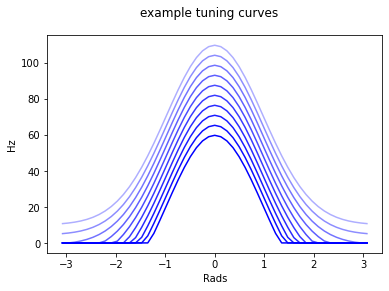

In [2]:
num_bins = 51
num_thresholds = 10

diff = math.pi / num_bins     # only works for odd bins!
mean_bins = torch.arange(-25, 26)
std_angles = torch.ones(num_bins)
scales = 250 * torch.ones(num_bins)
thresholds = torch.linspace(-10, 40, num_thresholds)

tuning_curve_vectors = gaussian_on_a_circle(num_bins, mean_bins, std_angles, scales, torch.zeros_like(mean_bins))

fig, axes = plt.subplots(1)
fig.suptitle('example tuning curves')
axes.set_ylabel('Hz')
axes.set_xlabel('Rads')

tcvn = tuning_curve_vectors

for i in range(num_thresholds):
    axes.plot(np.arange(-25, 26) * (2 * math.pi) / (num_bins), torch.relu(tcvn[25] - thresholds[i]).numpy(), alpha = ((i + 1) / num_thresholds)**0.5, color="blue")

tuning_curves = AngularThresholdedTuningCurve(tuning_curve_vectors, thresholds = thresholds)
population = IndependentPoissonPopulationResponse([tuning_curves])

The object `population` carries the ability to take (uncertain) perceptions from the stimuli we provide.

We now define the stimulus basis function set, which in our case is a set of two vectors defining the stimulus strength at 51 points around a circle

Text(0.5, 1.0, 'Uncertainty')

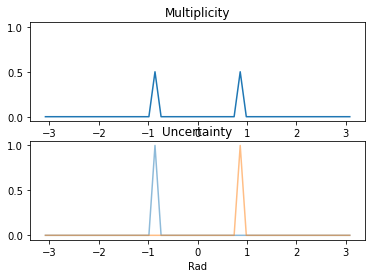

In [3]:
# First, define the functions around a circle with which we are concerned
m_basis_vectors  = torch.zeros(num_bins, 2)
m_basis_vectors[18, 0] = 1.0
m_basis_vectors[32, 1] = 1.0

# Wrap this in the object
m_basis = VectorisedStimulusBasisFunctionSet(m_basis_vectors)

# In this example, we only deal with one true distribution p(m) over basis functions:
uncertain_mixing_proportions = torch.ones(1, 2) / 2

# From this, let's define two stimulus possibilities:
stimulus_1 = m_basis.multiplicative_stimulus(uncertain_mixing_proportions)
stimulus_2a, stimulus_2b = (m_basis.full_basis() * torch.ones(1, 2)).T

# And let's display them
fig, axes = plt.subplots(2)

theta = torch.arange(-25, 26) * (2 * math.pi) / (num_bins)
axes[0].plot(theta.numpy(), stimulus_1[0].numpy())
axes[1].plot(theta.numpy(), stimulus_2a.numpy(), alpha = 0.5)
axes[1].plot(theta.numpy(), stimulus_2b.numpy(), alpha = 0.5)

axes[0].set_ylim(-0.05, 1.05)
axes[1].set_ylim(-0.05, 1.05)

axes[1].set_xlabel('Rad')

axes[0].set_title('Multiplicity')
axes[1].set_title('Uncertainty')

As mentioned, the `population` object takes views of the stimuli we define.

Here, we find both the ideal (mean) encoded rates, and the true rates over a 0.1s period when a Poisson spike train is simulated from this set of mean rates

In [24]:
# Duration of viewing
duration = 0.1


encoded_rates_multivalued = population.population_mean_firing_rate(stimulus_1)  # These are the means, which are unseen!
observed_rates_multivalued = population.empirical_rates_from_encoded_rates(encoded_rates_multivalued, duration) # These are the observed ris

encoded_rates_uncertain = population.uncertain_response(m_basis, uncertain_mixing_proportions) # Again, unseen
observed_rates_uncertain = population.empirical_rates_from_encoded_rates(encoded_rates_uncertain, duration) # Again ris

The encoded rates are different in each case:

Text(0.5, 1.0, 'Uncertainty')

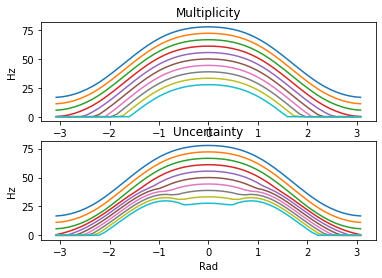

In [5]:
fig, axes = plt.subplots(2)

for i in range(num_thresholds):
    axes[0].plot(theta.numpy(), encoded_rates_multivalued[0, i::num_thresholds].numpy())
    axes[1].plot(theta.numpy(), encoded_rates_uncertain[0, i::num_thresholds].numpy())

axes[1].set_xlabel('Rad')

axes[0].set_ylabel('Hz')
axes[1].set_ylabel('Hz')

axes[0].set_title('Multiplicity')
axes[1].set_title('Uncertainty')

And the true rates are a noisy view of that

Text(0.5, 1.0, 'Uncertainty')

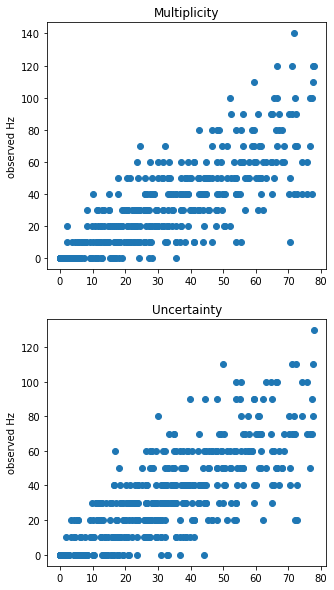

In [14]:
fig, axes = plt.subplots(2, figsize = (5, 10))

axes[0].scatter(encoded_rates_multivalued, observed_rates_multivalued, marker = 'o')
axes[1].scatter(encoded_rates_uncertain, observed_rates_uncertain, marker = 'o')

axes[0].set_ylabel('encoded Hz')
axes[0].set_ylabel('observed Hz')

axes[1].set_ylabel('encoded Hz')
axes[1].set_ylabel('observed Hz')

axes[0].set_title('Multiplicity')
axes[1].set_title('Uncertainty')

## Decoding

There is no 'learning' of tuning curves here, so we can precalculate the individual encoding
responses of each neuron to all the possible stimuli (i.e. all the m(s) functions)
all_phis[m,i] is called called phi_i(m) in the paper (again, m is a vectorised function in the paper)

In [22]:
all_m_vectors = grid_points([100, 100], [-0.5, -0.5], [2.0, 2.0])

all_m_functions = m_basis.multiplicative_stimulus(all_m_vectors)

all_phis = population.population_mean_firing_rate(all_m_functions)

The paper uses an iterative procedure to find the MAP identity of $q(m)$. In the future it might be worth comparing to a constrained GD process!

In [21]:
def iterative_optimisation(observed_rates, q_m, phis, alpha, num_iter):
    counter = 0

    for i in tqdm(range(num_iter)):
        
        q_tilde = q_m / phis.sum(1)   # Unnormalised estimate
        r_hats = q_m @ phis # E_q [ phi_i ]

        # Equation 11
        new_q_tilde = q_tilde * (
            ((observed_rates / r_hats).nan_to_num(0.0) * phis).sum(-1)
            - ((alpha / duration) * (1 + q_m.log()))
        )

        # Equation 12
        q_m = new_q_tilde + q_tilde * (
            (1 - new_q_tilde.sum()) / 
            (q_tilde.sum())
        )

        if torch.isnan(q_m.sum()):
            raise ValueError

    return q_m

$q(m)$, an exstimate of $p(m)$, is a distribution over functions, but our basis function is defined via two dimension vectors
$q(m)$ is effectively a pmf over 10000 values of $[-0.5, 2.0]^2$, i.e. a 100x100 grid over this range
We initialise it to a uniform over this domain, and define the domain itself

Regenerating observed rates here as sometimes there are numerical instabilities

In [51]:
observed_rates_uncertain = population.empirical_rates_from_encoded_rates(encoded_rates_uncertain, duration) # Again ris
observed_rates_multivalued = population.empirical_rates_from_encoded_rates(encoded_rates_multivalued, duration) # These are the observed ris

q_m0 = torch.ones(all_m_vectors.shape[0]) / all_m_vectors.shape[0]

alpha = 1.0
num_iter = 4000

q_m_uncertain = iterative_optimisation(observed_rates_uncertain, q_m0, all_phis, alpha, num_iter)
q_m_multivalued = iterative_optimisation(observed_rates_multivalued, q_m0, all_phis, alpha, num_iter)

100%|██████████| 4000/4000 [00:06<00:00, 617.21it/s]


Text(0.5, 1.0, 'Uncertainty')

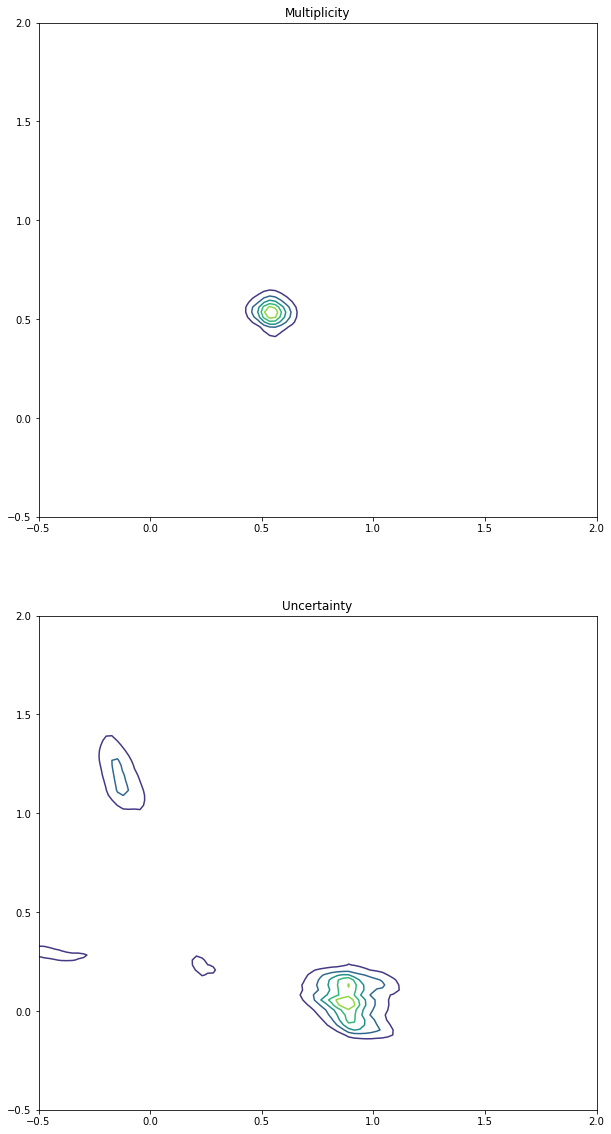

In [52]:
X, Y = np.meshgrid(np.linspace(-0.5, 2, 100), np.linspace(-0.5, 2, 100))


Z1 = q_m_multivalued.numpy().reshape(100, 100)
levels1 = np.linspace(np.min(Z1), np.max(Z1), 7)


Z2 = q_m_uncertain.numpy().reshape(100, 100)
levels2 = np.linspace(np.min(Z2), np.max(Z2), 7)


# plot
fig, axes = plt.subplots(2, figsize = (10, 20))

axes[0].contour(X, Y, Z1, levels=levels1)
axes[1].contour(X, Y, Z2, levels=levels2)

axes[0].set_title('Multiplicity')
axes[1].set_title('Uncertainty')